In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def cutWeek(weekNumber, data):
    weekdata = []
    for i in range(weekNumber):
         temp = data[data.Week_Number == i]
         temp = temp.reset_index(drop=True)
         weekdata.append(temp)
    return weekdata

def labelMapping(year, week, label):
    labelMap = {}
    for (y, w, l) in zip(year, week, label):
        key = (y, w)
        value = l
        labelMap[key] = value
    return labelMap

def proficCalculator(data, fund):
    # Week 0 case
    week1Data = data[0]
    week1Label = week1Data.Label[0] # week 0 label

    if week1Label == 1:
        stock = True
        buyPrice = week1Data.Close[0] # week 0 first day price
        sellPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price
    else:
        stock = False
        buyPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price
        sellPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price


    for df in data[1:]:
        nextWeekColor = df.Label[0]
        nextClosePrice = df.Close[len(df)-1]

        # stock + green = no action
        if (stock == True) and (nextWeekColor == 1):
            stock == True # Keep holding the stock
            buyPrice = buyPrice # Buy point stay
            sellPrice = nextClosePrice # Sell point move forward

        # stock + red = sell
        elif (stock == True) and (nextWeekColor == 0):
            r = 1 + (sellPrice - buyPrice) / sellPrice
            fund = fund * r
            buyPrice = nextClosePrice
            sellPrice = nextClosePrice
            stock = False
            
        # money + green = buy stock
        elif (stock == False) and (nextWeekColor == 1):
            buyPrice = buyPrice
            sellPrice = nextClosePrice
            stock = True
        # money + red = no action
        elif (stock == False) and (nextWeekColor == 0):
            buyPrice = nextClosePrice
            sellPrice = nextClosePrice
            stock = False

    # Last withdraw
    r = 1 + (sellPrice - buyPrice) / sellPrice
    fund = fund * r
    return fund

In [3]:
dfLabel = pd.read_csv('./GOOGL_weekly_return_volatility.csv')
year1 = dfLabel[dfLabel.Year == 2019]
year2 = dfLabel[dfLabel.Year == 2020]

In [4]:
xTrain = year1[['mean_return', 'volatility']]
yTrain = year1.label
xTest = year2[['mean_return', 'volatility']]
yTest = year2.label

# Error Map

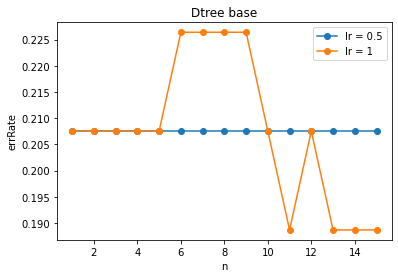

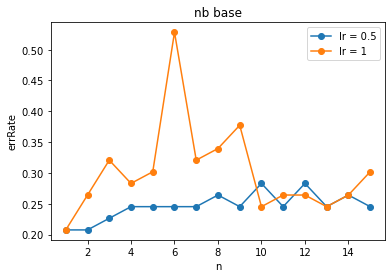

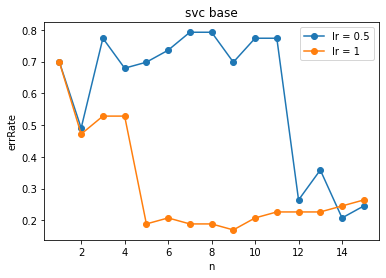

In [34]:

log = LogisticRegression(random_state = 0)
nb = GaussianNB()
svc = SVC(probability=True, kernel='linear', random_state=0)
dTree = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2, random_state=0)

lrList = [0.5, 1]
nList = [i+1 for i in range(15)]

# log base
plt.figure(1)
for lr in lrList:
    e = []
    for n in nList:
        clf = AdaBoostClassifier(base_estimator=dTree, n_estimators=n, learning_rate=lr, random_state=0)
        clf.fit(xTrain, yTrain)
        yPredict = clf.predict(xTest)
        e.append( np.mean(yPredict != yTest) )
    plt.title('Dtree base')
    plt.xlabel('n')
    plt.ylabel('errRate')
    plt.plot(nList, e,marker='o',  label = 'lr = {}'.format(lr))
    plt.legend()

# nb base
plt.figure(2)
for lr in lrList:
    e = []
    for n in nList:
        clf = AdaBoostClassifier(base_estimator=nb, n_estimators=n, learning_rate=lr, random_state=0)
        clf.fit(xTrain, yTrain)
        yPredict = clf.predict(xTest)
        e.append( np.mean(yPredict != yTest) )
    plt.title('nb base')
    plt.xlabel('n')
    plt.ylabel('errRate')
    plt.plot(nList, e,marker='o',  label = 'lr = {}'.format(lr))
    plt.legend()

# svc base
plt.figure(3)
for lr in lrList:
    e = []
    for n in nList:
        clf = AdaBoostClassifier(base_estimator=svc, n_estimators=n, learning_rate=lr, random_state=0)
        clf.fit(xTrain, yTrain)
        yPredict = clf.predict(xTest)
        e.append( np.mean(yPredict != yTest) )
    plt.title('svc base')
    plt.xlabel('n')
    plt.ylabel('errRate')
    plt.plot(nList, e,marker='o',  label = 'lr = {}'.format(lr))
    plt.legend()

# Accuracy for each base learner

In [30]:
# dtree, lr=1, n=11
clf = AdaBoostClassifier(base_estimator=dTree, n_estimators=11, learning_rate=1, random_state=0)
clf.fit(xTrain, yTrain)
yPredict = clf.predict(xTest)
print(accuracy_score(yTest, yPredict))




# nb, lr=0.5, n=2
clf = AdaBoostClassifier(base_estimator=nb, n_estimators=2, learning_rate=0.5, random_state=0)
clf.fit(xTrain, yTrain)
yPredict = clf.predict(xTest)
print(accuracy_score(yTest, yPredict))

# svc, lr = 1, n = 9
clf = AdaBoostClassifier(base_estimator=svc, n_estimators=9, learning_rate=1, random_state=0)
clf.fit(xTrain, yTrain)
yPredict = clf.predict(xTest)
print(accuracy_score(yTest, yPredict))


0.8113207547169812
0.7924528301886793
0.8301886792452831


# Trading strategy

# using svc

In [32]:
clf = AdaBoostClassifier(base_estimator=svc, n_estimators=9, learning_rate=1, random_state=0)
clf.fit(xTrain, yTrain)
yPredict = clf.predict(xTest)


In [33]:
# Strategy check
dfDetail = pd.read_csv('./GOOGL_weekly_return_volatility_detailed.csv')
year2Detail = dfDetail[dfDetail.Year == 2020]
year2Detail = year2Detail.reset_index(drop = True)

## Add label to detail
lMap = labelMapping(year2.Year, year2.Week_Number, yPredict)
temp = []
for (y, w) in zip(year2Detail.Year, year2Detail.Week_Number):
    key = (y, w)
    temp.append(lMap[key]) 
year2Detail['Label'] = temp
year2Detail = year2Detail[['Year', 'Week_Number', 'Close', 'Label']]

## Cut goo2020
goo2020Week = cutWeek(53, year2Detail)




## trading 
total = proficCalculator(goo2020Week, 100)
print("Using Label: {}".format(total))

## trding BH
firstWeek = goo2020Week[0]
firstClose = firstWeek.Close[0]

lastWeek = goo2020Week[-1]
lastClose = lastWeek.Close[len(lastWeek)-1]

r = 1 + (lastClose - firstClose) / lastClose
total = 100 * r
print("Buy on first day and Sell on last day: {}".format(total))

Using Label: 235.2381125163195
Buy on first day and Sell on last day: 121.17033527942765
